# Install Requirements

In [ ]:
# %pip install autosink-data-preparation
# %pip install autosink-data-validation
# %pip install autosink-model-evaluation
# %pip install autosink-model-training
# %pip install autosink-model-validation

In [1]:
%pip install -q git+https://github.com/slink-to-unlock/autosink-data-elt.git
# %pip install -q git+https://github.com/slink-to-unlock/autosink-data-preparation.git
# %pip install -q git+https://github.com/slink-to-unlock/autosink-data-validation.git
# %pip install -q git+https://github.com/slink-to-unlock/autosink-model-evaluation.git
%pip install -q git+https://github.com/slink-to-unlock/autosink-model-training.git
%pip install -q git+https://github.com/slink-to-unlock/autosink-model-validation.git
%pip install -q git+https://github.com/slink-to-unlock/sparse-to-dense.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

# Data Extraction

In [2]:
import os
from autosink_data_elt.path.autosink import AutosinkPath

path = AutosinkPath(
    data_lake_rel_dir=os.path.join('dev','autowash', 'data', 'data-lake'),
    feature_store_rel_dir=os.path.join('dev','autowash', 'data', 'feature-store', 'train'),
)


'/content/mnt/MyDrive/dev/autowash/data/feature-store/train/v5'

In [3]:
from google.colab import drive

drive.mount(path.mount_dir)

Mounted at /content/mnt


In [ ]:
import os
from urllib import request
PORT = 8501

from autosink_data_elt.tools import unzip

waiting_data_dir = os.path.join(path.data_lake_dir, 'extract')
unzip(path.data_lake_dir, waiting_data_dir)

# run in background
!nohup python3 -m sparse_to_dense.cli.web \
    --port {PORT} \
    --workspace_path {waiting_data_dir} \
    --feature_store_path {path.next_dataset_root_dir} > logs.txt &
!nohup npx localtunnel --port {PORT} > logs-localtunnel.txt &

print('My IP (Password):', request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip('\n'))
!sleep 10 && cat logs-localtunnel.txt && cat logs.txt

nohup: redirecting stderr to stdout
nohup: redirecting stderr to stdout
My IP (Password): 35.236.130.239
npx: installed 22 in 3.986s
your url is: https://free-cars-walk.loca.lt
/usr/bin/python3: Error while finding module specification for 'sparse_to_dense.cli.web' (ModuleNotFoundError: No module named 'sparse_to_dense.cli')


- 데이터 레이블링이 필요한 상황이라면 위 셀 실행 결과에 출력되는 링크를 여세요.
- 링크의 빈칸에 `My IP (Password)` 값을 복사해 넣으세요.
- `Autosink` 프로젝트의 레이블러를 Google COLAB 에서 실행시킬 수 있습니다.

# Data Preparation

In [4]:
from autosink_model_training.dataset import load_custom_dataset
data_dir = path.latest_dataset_root_dir
dataset = load_custom_dataset(data_dir)

Resolving data files:   0%|          | 0/2467 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
from autosink_model_training.preprocess import data_preprocess, split_dataset
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/resnet-50')
preprocessed_dataset= data_preprocess(dataset, feature_extractor)
train_dataset, eval_dataset = split_dataset(preprocessed_dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


Map:   0%|          | 0/2467 [00:00<?, ? examples/s]

# Data validation

In [ ]:
import wandb
from collections import Counter
import numpy as np

# W&B 설정
run = wandb.init(project="AIsink-resnet50",name='data_validation',entity="zzangsu")

# 클래스 분포 분석
labels = [example['label'] for example in dataset['train']]
label_counts = Counter(labels)
class_distribution_table = wandb.Table(data=[[label, count] for label, count in label_counts.items()], columns=["label", "count"])
wandb.log({"class_distribution": wandb.plot.bar(class_distribution_table, "label", "count", title="Class Distribution")})


# 객체성(objectness) 분석
# 간단한 객체성 측정을 위한 예시 코드 (여기서는 중심의 밝기 값 평균을 객체성으로 사용)
def calculate_objectness(img):
    center_region = img.crop((img.width//4, img.height//4, 3*img.width//4, 3*img.height//4))
    return np.array(center_region).mean()

objectness_scores = [calculate_objectness(example['image']) for example in dataset['train']]
wandb.log({"objectness_scores": wandb.Histogram(np.array(objectness_scores))})

run.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Model Training

In [6]:
from autosink_model_training.train import AIsinkTrainer
from transformers import AutoModelForImageClassification
import wandb
#latest model load
run = wandb.init(project="AIsink-resnet50",name='pretrained_model_load')
artifact = run.use_artifact('zzangsu/AIsink-resnet50/model-ai-sink-run:success', type='model')
artifact_dir = artifact.download()
model = AutoModelForImageClassification.from_pretrained(artifact_dir,ignore_mismatched_sizes=True, num_labels=2)
run.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact model-ai-sink-run:latest, 89.94MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:3.8


In [7]:
from autosink_model_training.train import AIsinkTrainer

ai_sink_trainer = AIsinkTrainer(model=model, train_dataset=train_dataset, eval_dataset=eval_dataset)
ai_sink_trainer.train()

wandb: Currently logged in as: subinaksl (zzangsu). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.093100,0.188194,0.955466
2,0.099000,0.168844,0.965587
3,0.019800,0.191663,0.959514
4,0.007600,0.231122,0.961538
5,0.009600,0.197699,0.965587


wandb: Adding directory to artifact (./results/checkpoint-247)... Done. 3.5s
wandb: Adding directory to artifact (./results/checkpoint-494)... Done. 1.3s
wandb: Adding directory to artifact (./results/checkpoint-741)... Done. 1.2s
wandb: Adding directory to artifact (./results/checkpoint-988)... Done. 1.4s
wandb: Adding directory to artifact (./results/checkpoint-1235)... Done. 4.6s


# Model Evaluation

In [8]:
eval_metrics = ai_sink_trainer.trainer.evaluate(eval_dataset)
ai_sink_trainer.trainer.log_metrics("eval set", eval_metrics)
ai_sink_trainer.trainer.save_metrics("eval set", eval_metrics)

***** eval set metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9656
  eval_loss               =     0.1688
  eval_runtime            = 0:00:54.78
  eval_samples_per_second =      9.016
  eval_steps_per_second   =      1.132


In [73]:
outputs = ai_sink_trainer.trainer.predict(eval_dataset)

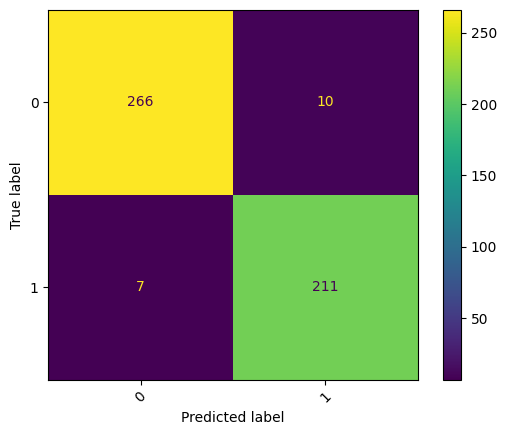

In [77]:
c=confusionmatrix(outputs,eval_dataset)

# Model Validation

In [88]:
import os

def get_label_from_path(path):
    # 경로에서 폴더 이름 추출
    folder_name = os.path.basename(path)

    # 폴더 이름을 '-'로 분리
    parts = folder_name.split('-')

    # 두 번째 요소를 레이블로 추출
    label = parts[1]

    return int(label)

# 사용 예시
# case_data_dir = '/content/mnt/MyDrive/dev/autowash/data/feature-store/validation/v2/raw_so/CASE03-0-세제-손o-수세미o'
# label = get_label_from_path(case_data_dir)
# print(f"The label extracted from the path is: {label}")  # 출력: The label extracted from the path is: 0


In [95]:
from autosink_model_training.preprocess import data_preprocess_eval
from autosink_model_validation.utils import check_model, confusionmatrix, val_accuracy

outputs_list = []
case_root = '/content/mnt/MyDrive/dev/autowash/data/feature-store/validation/v2/raw_so'
print('case foler root:', case_root)

for case_dir in os.listdir(case_root):
  print(case_dir)
  if len(os.listdir(os.path.join(case_root,case_dir)))==0:
    continue
  label = get_label_from_path(os.path.join(case_root,case_dir))
  print(f"The label extracted from the path is: {label}")  # 출력: The label extracted from the path is: 0
  case_dataset = load_custom_dataset(os.path.join(case_root,case_dir))
  case_preprocessed_dataset= data_preprocess_eval(case_dataset, feature_extractor,label)
  outputs = val_accuracy(ai_sink_trainer.trainer, case_preprocessed_dataset)

  # 데이터셋 이름 출력
  print(f"Dataset: {os.path.basename(case_dir)}")
  print("Metrics:")
  for key, value in outputs.metrics.items():
      print(f"{key}: {value}")

  outputs_list.append(outputs.metrics['test_accuracy'])



case foler root: /content/mnt/MyDrive/dev/autowash/data/feature-store/validation/v2/raw_so
CASE03-0-세제-손o-수세미o
The label extracted from the path is: 0


Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

Dataset: CASE03-0-세제-손o-수세미o
Metrics:
test_loss: 6.402317376341671e-05
test_accuracy: 1.0
test_runtime: 13.8696
test_samples_per_second: 3.317
test_steps_per_second: 0.433
CASE04-0-세제-손o-수세미o-식기o
The label extracted from the path is: 0


Resolving data files:   0%|          | 0/209 [00:00<?, ?it/s]

Dataset: CASE04-0-세제-손o-수세미o-식기o
Metrics:
test_loss: 0.00020208826754242182
test_accuracy: 1.0
test_runtime: 36.2594
test_samples_per_second: 5.764
test_steps_per_second: 0.745
CASE05-1-헹굼-물o-식기가까움
The label extracted from the path is: 1


Resolving data files:   0%|          | 0/158 [00:00<?, ?it/s]

Dataset: CASE05-1-헹굼-물o-식기가까움
Metrics:
test_loss: 4.931034564971924
test_accuracy: 0.04430379746835443
test_runtime: 23.6361
test_samples_per_second: 6.685
test_steps_per_second: 0.846
CASE06-0-헹굼-물o-식기멀리떨어짐
CASE09-0-헹굼-물x-식기멀리떨어짐
The label extracted from the path is: 0


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Dataset: CASE09-0-헹굼-물x-식기멀리떨어짐
Metrics:
test_loss: 0.00021557013678830117
test_accuracy: 1.0
test_runtime: 0.8733
test_samples_per_second: 10.306
test_steps_per_second: 2.29
CASE07-0-헹굼-물o-식기x
CASE10-0-헹굼-물x-식기x
The label extracted from the path is: 0


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Dataset: CASE10-0-헹굼-물x-식기x
Metrics:
test_loss: 0.00011518001701915637
test_accuracy: 1.0
test_runtime: 0.4924
test_samples_per_second: 10.155
test_steps_per_second: 2.031


In [96]:
check_model(outputs_list)

not success
